Packages Installed:
1. pretty_midi
2. pyfluidsynth

pretty_midi library is used to create and parse MIDI files, and pyfluidsynth for generating audio playback in Colab

## Imports

In [1]:
import os
import collections
import datetime
import glob
import pathlib
import pretty_midi
import fluidsynth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from IPython import display
from typing import Dict, List, Optional, Sequence, Tuple
from pandas import DataFrame

2025-02-23 23:42:52.555531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set the seed

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
SAMPLING_RATE = 16000

# Download the dataset if it does not exist locally under data directory

In [3]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True, 
        cache_dir='.',
        cache_subdir='data'
    )

# Read the MIDI files

In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))

In [5]:
len(filenames)

1282

In [6]:
filenames[100]

'data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--4.midi'

## Generate a PrettyMIDI object for the sample MIDI file

In [7]:
sample = filenames[286]

In [8]:
pm = pretty_midi.PrettyMIDI(sample)

In [9]:
pm

## Play the sample file

In [10]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds = 15):
    waveform = pm.fluidsynth(fs = SAMPLING_RATE)      # Function calll to fluidSynth to generate music i.e. convert MIDI files into audion
    
    waveform_short = waveform[:seconds * SAMPLING_RATE]
    return display.Audio(waveform_short, rate=SAMPLING_RATE)

In [11]:
display_audio(pm)

## Do some inspection on the MIDI file

In [12]:
print(f'Number of Instruments: {len(pm.instruments)}')
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name: ', instrument_name)

Number of Instruments: 1
Instrument name:  Acoustic Grand Piano


# Extract notes

In [13]:
instrument

Instrument(program=0, is_drum=False, name="")

In [14]:
instrument.notes[:5]

[Note(start=1.026042, end=1.121875, pitch=75, velocity=29),
 Note(start=1.055208, end=1.164583, pitch=63, velocity=18),
 Note(start=1.420833, end=1.466667, pitch=75, velocity=35),
 Note(start=1.451042, end=1.515625, pitch=63, velocity=16),
 Note(start=1.761458, end=1.812500, pitch=75, velocity=44)]

In [15]:
len(instrument.notes)

4011

In [16]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch = {note.pitch}, note_name: {note_name}, duration = {duration:.4f}')

0: pitch = 75, note_name: D#5, duration = 0.0958
1: pitch = 63, note_name: D#4, duration = 0.1094
2: pitch = 75, note_name: D#5, duration = 0.0458
3: pitch = 63, note_name: D#4, duration = 0.0646
4: pitch = 75, note_name: D#5, duration = 0.0510
5: pitch = 63, note_name: D#4, duration = 0.0792
6: pitch = 87, note_name: D#6, duration = 0.0542
7: pitch = 99, note_name: D#7, duration = 0.0938
8: pitch = 99, note_name: D#7, duration = 0.0521
9: pitch = 87, note_name: D#6, duration = 0.0365


### We will use three variable to represent a note when training the model: pitch, step and duration. The pitch is the perceptual quality of the sound as a MIDI note number. The step is the time elapsed from the previous note or start of the track. The duration is how long the note will be playing in seconds and is the difference between the note end and note start times



In [38]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    
    # sort the notes by starting time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    previous_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - previous_start)
        notes['duration'].append(end - start)
        previous_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [39]:
raw_notes = midi_to_notes(sample)
raw_notes.head()

,pitch,start,end,step,duration
0,75,1.026042,1.121875,0.000000,0.095833
1,63,1.055208,1.164583,0.029167,0.109375
2,75,1.420833,1.466667,0.365625,0.045833
3,63,1.451042,1.515625,0.030208,0.064583
4,75,1.761458,1.812500,0.310417,0.051042


In [19]:
raw_notes.shape

(4011, 5)

### It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitvh values to note names. The note name shows the type of note, accidental and octave number (C#4)

In [20]:
get_note_name = np.vectorize(pretty_midi.note_number_to_name)
sample_note_name = get_note_name(raw_notes['pitch'])
sample_note_name[:10]

array(['D#5', 'D#4', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

## Plot the distribution of pitch, step, & duration

In [21]:
def plot_distributions(notes: DataFrame, drop_percentile = 2.5):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x = 'pitch', bins = 20)
    
    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x = 'step', bins=np.linspace(0, max_step, 21))
    
    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x = 'duration', bins = np.linspace(0, max_duration, 21))
    
    plt.show()

/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anilthapa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


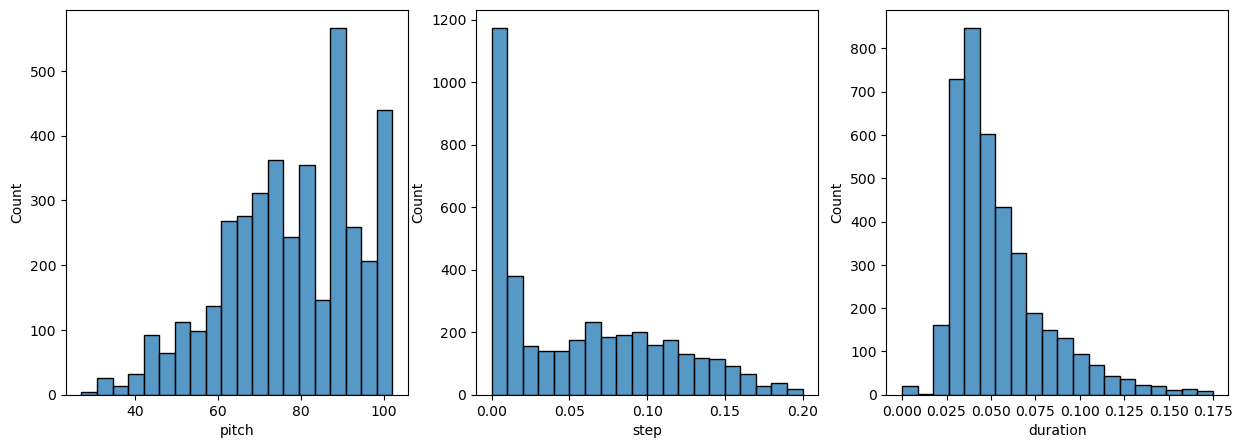

In [22]:
plot_distributions(raw_notes)

# Create the training dataset

In [23]:
num_files = 10
all_notes = []
for file in filenames[:num_files]:
    notes = midi_to_notes(file)
    all_notes.append(notes)
    
all_notes = pd.concat(all_notes)

In [24]:
num_notes = len(all_notes)
print(f'Number of notes processed:', num_notes)

Number of notes processed: 40031


In [25]:
key_order = ['pitch', 'step', 'duration']
train_notes =np.stack([all_notes[key] for key in key_order], axis = 1)

In [26]:
train_notes.shape

(40031, 3)

In [27]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [28]:
for item in notes_ds.take(5):
    print(item)

tf.Tensor([77.          0.          0.09244792], shape=(3,), dtype=float64)
tf.Tensor([4.9000000e+01 3.9062500e-03 4.0234375e-01], shape=(3,), dtype=float64)
tf.Tensor([7.30000000e+01 1.09375000e-01 6.51041667e-02], shape=(3,), dtype=float64)
tf.Tensor([6.80000000e+01 9.89583333e-02 6.11979167e-02], shape=(3,), dtype=float64)
tf.Tensor([7.30000000e+01 1.08072917e-01 5.98958333e-02], shape=(3,), dtype=float64)


2025-02-23 23:43:04.963484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Create the sequence

In [43]:
def create_sequence(dataset: tf.data.Dataset,
                   sequence_length: int,
                   vocab_size = 128,) -> tf.data.Dataset:
    sequence_length = sequence_length + 1
    
    windows = dataset.window(sequence_length, stride=1, shift = 1, drop_remainder=True)
    flatten = lambda x: x.batch(sequence_length, drop_remainder= True)
    sequences = windows.flat_map(flatten)
    
    # Normalize the pitch
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x
    
    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}
        
        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
sequence_length = 25
vocab_size = 128
seq_ds = create_sequence(notes_ds, sequence_length, vocab_size)

In [45]:
batch_size = 64
buffer_size = num_notes - sequence_length

In [32]:
train_ds =(seq_ds
           .shuffle(buffer_size)
           .batch(batch_size, drop_remainder=True)
           .cache()
           .prefetch(tf.data.experimental.AUTOTUNE)
          )

# Create the Model

## Custom Loss function

In [33]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_predict: tf.Tensor):
    mse = (y_true - y_predict) ** 2
    positive_pressure = 10 * tf.maximum(-y_predict, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [34]:
learning_rate = 0.01

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((sequence_length, 3)),
    tf.keras.layers.LSTM(128),
    tf.keras
])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <module 'keras._tf_keras.keras' from '/Users/anilthapa/anaconda3/lib/python3.11/site-packages/keras/_tf_keras/keras/__init__.py'> (of type <class 'module'>)